### Imported Libraries

In [7]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib
import multiprocessing
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

pd.options.display.max_rows = 300

### Feature Extraction Functions

In [8]:
beta = pd.read_feather("beta/betas_condensed.fth")
spread_dom = pd.read_csv("all_times.csv").drop(["beta"],axis=1)
DENORM = pd.read_csv("denormalize_multipliers.csv")

def mad(data):
    return np.mean(np.absolute(data - np.mean(data)))

def import_beta(df):
    global beta
    global spread_dom
    df = pd.merge(df, beta, how="left")
    df = pd.merge(df, spread_dom, how="left")
    return df
    
def compute_wap(df):
    return (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) \
          /(df['bid_size1'] + df['ask_size1'])

def compute_wap2(df):
    return (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) \
           /(df['bid_size2'] + df['ask_size2'])

def compute_dom(df):
    dom = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2']) \
            + (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])
    return dom

def compute_dom_diff(df):
    dom_diff = abs((df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2']) \
            - (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2']))
    return dom_diff

def fill_seconds(df):
    df = df.reset_index(drop=True)
    index_range = pd.Index(range(600), name='seconds_in_bucket')
    df = df.set_index('seconds_in_bucket').reindex(index_range)
    
    # Forward fill & back fill seconds
    df = df.ffill().reset_index()
    return df.bfill().iloc[:600]

def beta_encoding(df):
    beta1 = np.repeat(np.nan, df.shape[0])
    beta2 = np.repeat(np.nan, df.shape[0])
    kf = KFold(n_splits = 112, shuffle=True,random_state = 0)
    for idx_1, idx_2 in kf.split(df):
        bmean1 = df.iloc[idx_1].groupby('stock_id')['beta'].mean()
        bmean2 = df.iloc[idx_1].groupby('stock_id')['beta2'].mean()
        beta1[idx_2] = df['stock_id'].iloc[idx_2].map(bmean1)
        beta2[idx_2] = df['stock_id'].iloc[idx_2].map(bmean2)
        
    df['encode_mean_beta'] = beta1
    df['encode_mean_beta2'] = beta2
    
    return df.drop(['beta','beta2'], axis=1)

def target_encoding(df):
    tenc = np.repeat(np.nan, df.shape[0])
    senc = np.repeat(np.nan, df.shape[0])
    denc = np.repeat(np.nan, df.shape[0])
    tencs = np.repeat(np.nan, df.shape[0])
    sencs = np.repeat(np.nan, df.shape[0])
    dencs = np.repeat(np.nan, df.shape[0])
    kf = KFold(n_splits = 112, shuffle=True,random_state = 0)
    for idx_1, idx_2 in kf.split(df):
        tmean = df.iloc[idx_1].groupby('stock_id')['target_realized_volatility'].mean()
        smean = df.iloc[idx_1].groupby('stock_id')['spread'].mean()
        dmean = df.iloc[idx_1].groupby('stock_id')['dom'].mean()
        tmeans = df.iloc[idx_1].groupby('stock_id')['target_realized_volatility'].std()
        smeans = df.iloc[idx_1].groupby('stock_id')['spread'].std()
        dmeans = df.iloc[idx_1].groupby('stock_id')['dom'].std()
        tenc[idx_2] = df['stock_id'].iloc[idx_2].map(tmean)
        senc[idx_2] = df['stock_id'].iloc[idx_2].map(smean)
        denc[idx_2] = df['stock_id'].iloc[idx_2].map(dmean)
        tencs[idx_2] = df['stock_id'].iloc[idx_2].map(tmeans)
        sencs[idx_2] = df['stock_id'].iloc[idx_2].map(smeans)
        dencs[idx_2] = df['stock_id'].iloc[idx_2].map(dmeans)
    df['target_mean_enc'] = tenc
    df['spread_mean_enc'] = senc
    df['dom_mean_enc'] = denc
    df['target_std_enc'] = tencs
    df['spread_std_enc'] = sencs
    df['dom_std_enc'] = dencs
    
    return df.drop(['dom','spread'], axis=1)

def generate_feature_seconds(features, df, feats, seconds=[300], overlap=1):
    if overlap:
        for second in seconds:
            res = pd.DataFrame(
                df.query(f'{seconds[0]-second} <= seconds_in_bucket < {seconds[0]}')
                .groupby(['time_id']).agg(feats)
            ).reset_index()
            res.columns = ['_'.join(feat).rstrip('_') for feat in res.columns]
            res = res.add_suffix('_' + str(second))
            features = pd.merge(
                features, res, 
                how='left', 
                left_on='time_id', 
                right_on=f'time_id_{second}'
            )
            features = features.drop([f'time_id_{second}'], axis=1)  
    else:
        for i, second in enumerate(seconds):
            last_second = 0 if not i else seconds[i-1]
            res = pd.DataFrame(
                df.query(f'{last_second} <= seconds_in_bucket < {second}')
                .groupby(['time_id']).agg(feats)
            ).reset_index()
            res.columns = ['_'.join(feat).rstrip('_') for feat in res.columns]
            res = res.add_suffix('_' + str(second))
            features = pd.merge(
                features, res, 
                how='left', 
                left_on='time_id', 
                right_on=f'time_id_{second}'
            )
            features = features.drop([f'time_id_{second}'], axis=1)
    return features

def generate_target(df, target, second=300):
    features = pd.DataFrame(
        df.query(f'seconds_in_bucket >= {second}')
        .groupby(['time_id']).agg(target)
    ).reset_index()
    features.columns = ['_'.join(feat).rstrip('_') for feat in features.columns]
    return features

def calc_slope(df):
    v0 = (df['bid_size1']+df['ask_size1'])/2
    p0 = (df['bid_price1']+df['ask_price1'])/2
    slope_bid = ((df['bid_size1']/v0)-1)/abs((df['bid_price1']/p0)-1)+(
                (df['bid_size2']/df['bid_size1'])-1)/abs((df['bid_price2']/df['bid_price1'])-1)
    slope_ask = ((df['ask_size1']/v0)-1)/abs((df['ask_price1']/p0)-1)+(
                (df['ask_size2']/df['ask_size1'])-1)/abs((df['ask_price2']/df['ask_price1'])-1)
    return (slope_bid+slope_ask)/2, abs(slope_bid-slope_ask)


def calc_dispersion(df):
    bspread = df['bid_diff']
    aspread = df['ask_diff']
    bmid = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price1']
    bmid2 = (df['bid_price1'] + df['ask_price1'])/2  - df['bid_price2']
    amid = df['ask_price1'] - (df['bid_price1'] + df['ask_price1'])/2
    amid2 = df['ask_price2'] - (df['bid_price1'] + df['ask_price1'])/2
    bdisp = (df['bid_size1']*bmid + df['bid_size2']*bspread)/(df['bid_size1']+df['bid_size2'])
    bdisp2 = (df['bid_size1']*bmid + df['bid_size2']*bmid2)/(df['bid_size1']+df['bid_size2'])
    adisp = (df['ask_size1']*amid + df['ask_size2']*aspread)/(df['ask_size1']+df['ask_size2'])      
    adisp2 = (df['ask_size1']*amid + df['ask_size2']*amid2)/(df['ask_size1']+df['ask_size2'])
    return (bdisp + adisp)/2, (bdisp2 + adisp2)/2

def calc_price_impact(df):
    ask = (df['ask_price1'] * df['ask_size1'] + df['ask_price2'] * df['ask_size2'])/(df['ask_size1']+df['ask_size2'])
    bid = (df['bid_price1'] * df['bid_size1'] + df['bid_price2'] * df['bid_size2'])/(df['bid_size1']+df['bid_size2'])
    return (df['ask_price1'] - ask)/df['ask_price1'], (df['bid_price1'] - bid)/df['bid_price1']


def calc_ofi(df):
    a = df['bid_size1']*np.where(df['bid_price1'].diff()>=0,1,0)
    b = df['bid_size1'].shift()*np.where(df['bid_price1'].diff()<=0,1,0)
    c = df['ask_size1']*np.where(df['ask_price1'].diff()<=0,1,0)
    d = df['ask_size1'].shift()*np.where(df['ask_price1'].diff()>=0,1,0)
    return a - b - c + d

def calc_tt1(df):
    p1 = df['ask_price1'] * df['ask_size1'] + df['bid_price1'] * df['bid_size1']
    p2 = df['ask_price2'] * df['ask_size2'] + df['bid_price2'] * df['bid_size2']      
    return p2 - p1 

def log_returns(waps):
    return np.log(waps).diff() 

def realized_volatility(log_returns):
    return np.sqrt(np.sum(log_returns**2))

def weighted_volatility(log_returns):
    return np.sqrt(np.sum(log_returns**2)/log_returns.count())

def quarticity(s):
    return (s.count()/3) * np.sum(s**4)

def denormalize(df):
    global DENORM

    df = df.merge(DENORM, how="left")
    df['ask_price1'] *= df['multiplier']
    df['ask_price2'] *= df['multiplier']
    df['bid_price1'] *= df['multiplier']
    df['bid_price2'] *= df['multiplier']
    
    return df.drop(['multiplier'], axis=1)

### Generate Features for First 5 Minutes of Each Stock 

In [9]:
def generate_features(stock_id, df):
    # fill seconds
    df = df.groupby('time_id').apply(fill_seconds).reset_index(drop=True)
    
    # compute waps for first and second ask/bids 
    df['wap'] = compute_wap(df)
    df['wap2'] = compute_wap2(df)
    
    # compute log returns for realized volatility
    df['log_returns'] = df.groupby('time_id')['wap'].apply(log_returns)
    df['log_returns2'] = df.groupby('time_id')['wap2'].apply(log_returns)
    
    # compute difference in waps and price as feature
    df['wap_diff'] = abs(df['wap'] - df['wap2'])
    
    # price difference regularized
    df['price_diff'] = (df['ask_price1'] - df['bid_price1']) \
                        / ((df['ask_price1'] + df['bid_price1'])/2)
    df['price_diff2'] = (df['ask_price2'] - df['bid_price2']) \
                        / ((df['ask_price2'] + df['bid_price2'])/2)
    
    # difference between first and second bid/ask price
    df['bid_diff'] = df['bid_price1'] - df['bid_price2']
    df['ask_diff'] = df['ask_price1'] - df['ask_price2']
    
    # sum of first and second ask sizes and bid sizes
    df['bid_ask_volume'] = (df['ask_size1'] + df['ask_size2']) \
                        + (df['bid_size1'] + df['bid_size2'])
    
    # diff between ask sizes and bid sizes 
    df['bid_ask_volume_diff'] = abs((df['ask_size1'] + df['ask_size2']) \
                                - (df['bid_size1'] + df['bid_size2']))

    # depth of market and difference
    df['dom'] = compute_dom(df)
    df['dom_diff'] = compute_dom_diff(df)
    df['dom_imbalance'] = abs(df['dom'] - df['dom_diff'])
    
    # bid ask spread from lecture/lab
    df["bid_ask_spread1"] = df['ask_price1'] / df['bid_price1'] - 1
    df["bid_ask_spread2"] = df['ask_price2'] / df['bid_price2'] - 1
    df['bid_ask_spread3'] = abs(df['bid_diff'] - df['ask_diff'])
    
    df["slope"], _ = calc_slope(df)
    df["dispersion"], _ = calc_dispersion(df)
    df["price_impact"], _ = calc_price_impact(df)
    df["ofi"] = calc_ofi(df)
    df["turn_over"] = calc_tt1(df)   
    
    df['target'] =  df.groupby('time_id')['wap'].apply(log_returns)
    
    target_dict = {'target':[realized_volatility]}
    feature_dict = {
        'wap':[np.mean, np.std],#, mad, np.max, np.sum],
        'wap2':[np.mean, np.std],#, mad, np.max, np.sum],
        'log_returns':[realized_volatility, weighted_volatility, 
                       quarticity, np.mean],# np.std, np.max],
        'log_returns2':[realized_volatility, weighted_volatility, 
                       quarticity, np.mean],# np.std, np.max],
        'wap_diff':[np.std, np.max],#, mad, np.max, np.sum],
        'price_diff':[np.max, np.std], #np.max, np.sum],#, mad, np.max, np.sum],
        'price_diff2':[np.max, np.std],#, np.max, np.sum],#, mad, np.max, np.sum],
        'bid_diff':[np.max, np.std],#, np.max, np.sum],#, mad, np.max, np.sum],
        'ask_diff':[np.max, np.std],#, np.max, np.sum],#, mad, np.max, np.sum],
        'bid_ask_volume':[np.mean, np.std, np.max],#, np.sum],#, mad, np.max, np.sum],
        'bid_ask_volume_diff':[np.mean, np.max],#, mad, np.max, np.sum],
        'dom':[np.mean, np.std, np.max],#, mad, np.max, np.sum],
        'dom_diff':[np.mean, np.std, np.max],#, mad, np.max, np.sum],
        'dom_imbalance':[np.mean, np.std, np.max],#, mad, np.max, np.sum],
        'bid_ask_spread1':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_spread2':[np.mean, np.std],#, mad, np.max, np.sum],
        'bid_ask_spread3':[np.mean, np.std],#, mad, np.max, np.sum],
        'slope':[np.mean, np.max, np.std],#, mad, np.max, np.sum],
        'dispersion':[np.mean, np.max],#, mad, np.max, np.sum],
        'price_impact':[np.mean, np.std, np.max],#, mad, np.max, np.sum],
        'ofi':[np.mean, np.std, np.max],#, mad, np.max, np.sum],
        'turn_over':[np.mean, np.std, np.max]#, mad, np.max, np.sum],
    }
    
    # target realized volatility for next 300 second (5 min window in time_id)
    feature = generate_target(
        df, target=target_dict, 
        second=300  # target volatility is for next 300 second (no overlap)
    )
    
    # obtain features over entire 5 mins or last 2.5 mins..
    
    feature = generate_feature_seconds(
        feature, df, 
        feats=feature_dict, 
        seconds=[300, 150, 75],  # features generated for each second interval (different widths)
        overlap=1,
    )
    #create stock_id
    feature['stock_id'] = int(stock_id)
    feature['time_id'] = feature['time_id'].apply(int)
    
    return feature

def concat_features(stock_id, df):
    f"individual_book_train/stock_{stock_id}.csv"
    stock_df = pd.read_csv(f"individual_book_train/stock_{stock_id}.csv")        
    return pd.concat([df, generate_features(stock_id, denormalize(stock_df))])

def process_stocks(stock_ids):
    df = pd.DataFrame()
    df = Parallel(n_jobs=-1, verbose=1)(
        delayed(concat_features)(stock_id, df) for stock_id in stock_ids
    )
    df = pd.concat(df, ignore_index = True)
    
    # lastly import pre-computed beta coefficients for all stock_ids
    df = import_beta(df)
    df = target_encoding(df)
    df = beta_encoding(df)
    
    return df

## Process Features for All Stocks

In [10]:
all_stocks = process_stocks(beta.stock_id.unique())
all_stocks

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  5.6min finished


,time_id,target_realized_volatility,wap_mean_300,wap_std_300,wap2_mean_300,wap2_std_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,...,beta-300,beta2-300,target_mean_enc,spread_mean_enc,dom_mean_enc,target_std_enc,spread_std_enc,dom_std_enc,encode_mean_beta,encode_mean_beta2
0,5,0.002954,194.495455,0.164908,194.479014,0.196558,0.003394,0.000196,4.521321e-10,7.138250e-06,...,0.737558,0.778640,0.002964,0.001023,391.300538,0.002289,0.000925,104.550467,0.635215,0.633070
1,11,0.000981,199.598260,0.031047,199.597336,0.036259,0.000699,0.000040,2.123766e-12,8.823633e-07,...,0.412667,0.450700,0.002976,0.001027,391.419207,0.002414,0.000949,104.729473,0.634261,0.632797
2,16,0.001295,209.021831,0.092861,209.053034,0.098250,0.001983,0.000115,1.070617e-10,1.729093e-06,...,4.284855,1.519335,0.002974,0.001025,390.605604,0.002411,0.000946,103.699696,0.632499,0.630289
3,31,0.001776,216.281256,0.183025,216.198136,0.164985,0.001863,0.000108,1.551546e-10,-5.516464e-06,...,3.499825,2.378868,0.002975,0.001026,391.181654,0.002411,0.000947,104.727931,0.636051,0.633793
4,62,0.001520,214.542788,0.051133,214.524415,0.071793,0.001131,0.000065,3.550845e-11,-2.164288e-06,...,0.250785,0.973303,0.002974,0.001027,391.062991,0.002412,0.000948,104.675748,0.633840,0.633266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,32751,0.002899,306.672174,0.163919,306.730549,0.206509,0.002284,0.000132,2.117007e-10,-2.858852e-06,...,3.484390,1.049953,0.003899,0.001108,382.917628,0.002595,0.000784,99.568403,0.961481,0.958937
428928,32753,0.003454,291.124934,0.147318,291.137380,0.164838,0.002217,0.000128,9.484441e-11,3.674218e-06,...,3.307661,2.160123,0.003897,0.001108,382.850800,0.002590,0.000783,99.572674,0.962304,0.960865
428929,32758,0.002792,202.972820,0.064758,202.958539,0.080424,0.001386,0.000080,3.031629e-11,-2.437732e-06,...,-0.570789,-0.046489,0.003903,0.001109,383.053325,0.002601,0.000786,99.715361,0.959879,0.957927
428930,32763,0.002379,152.478929,0.068413,152.480008,0.075165,0.002783,0.000161,1.960849e-10,6.737309e-06,...,0.959953,1.315896,0.003896,0.001108,382.605401,0.002593,0.000784,99.632305,0.961479,0.958523


In [11]:
all_stocks = all_stocks.reset_index(drop=True)
all_stocks.memory_usage()

Index                                       128
time_id                                 3431456
target_realized_volatility              3431456
wap_mean_300                            3431456
wap_std_300                             3431456
wap2_mean_300                           3431456
wap2_std_300                            3431456
log_returns_realized_volatility_300     3431456
log_returns_weighted_volatility_300     3431456
log_returns_quarticity_300              3431456
log_returns_mean_300                    3431456
log_returns2_realized_volatility_300    3431456
log_returns2_weighted_volatility_300    3431456
log_returns2_quarticity_300             3431456
log_returns2_mean_300                   3431456
wap_diff_std_300                        3431456
wap_diff_amax_300                       3431456
price_diff_amax_300                     3431456
price_diff_std_300                      3431456
price_diff2_amax_300                    3431456
price_diff2_std_300                     

In [12]:
del beta
del spread_dom  # don't need in memory anymore

### Rows with NaN are timeIDs that do not have extend2 chains
We will remove these rows as well

In [13]:
all_stocks[all_stocks.isna().any(axis=1)][['stock_id']+ list(all_stocks.columns.values[:9])]

,stock_id,time_id,target_realized_volatility,wap_mean_300,wap_std_300,wap2_mean_300,wap2_std_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300
107289,31,438,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0
107312,31,650,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0
107335,31,908,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0
107340,31,985,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0
107352,31,1070,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0
107380,31,1255,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0
107440,31,1712,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0
107454,31,1822,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0
107456,31,1826,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0
107495,31,2102,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0


In [14]:
DENORM[DENORM['multiplier'].isna()]

,stock_id,time_id,multiplier
176228,31,438,NaN
176251,31,650,NaN
176274,31,908,NaN
176279,31,985,NaN
176291,31,1070,NaN
176319,31,1255,NaN
176379,31,1712,NaN
176393,31,1822,NaN
176395,31,1826,NaN
176434,31,2102,NaN


In [15]:
all_stocks = all_stocks[~(all_stocks.isna().any(axis=1))]

### Removing row with zero realized volatility
* Only one row where target_realized_vol = 0
* Corrupts RMSPE and MAPE metric scores
    * Denominator is y_true
    * Added small epsilon to prevent zerodivision
    * Results in very large error if y_true = 0

In [16]:
len(all_stocks[all_stocks['target_realized_volatility']==0])

1

In [17]:
nozeros = all_stocks[all_stocks['target_realized_volatility'] != 0].reset_index(drop=True)
nozeros

,time_id,target_realized_volatility,wap_mean_300,wap_std_300,wap2_mean_300,wap2_std_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,...,beta-300,beta2-300,target_mean_enc,spread_mean_enc,dom_mean_enc,target_std_enc,spread_std_enc,dom_std_enc,encode_mean_beta,encode_mean_beta2
0,5,0.002954,194.495455,0.164908,194.479014,0.196558,0.003394,0.000196,4.521321e-10,7.138250e-06,...,0.737558,0.778640,0.002964,0.001023,391.300538,0.002289,0.000925,104.550467,0.635215,0.633070
1,11,0.000981,199.598260,0.031047,199.597336,0.036259,0.000699,0.000040,2.123766e-12,8.823633e-07,...,0.412667,0.450700,0.002976,0.001027,391.419207,0.002414,0.000949,104.729473,0.634261,0.632797
2,16,0.001295,209.021831,0.092861,209.053034,0.098250,0.001983,0.000115,1.070617e-10,1.729093e-06,...,4.284855,1.519335,0.002974,0.001025,390.605604,0.002411,0.000946,103.699696,0.632499,0.630289
3,31,0.001776,216.281256,0.183025,216.198136,0.164985,0.001863,0.000108,1.551546e-10,-5.516464e-06,...,3.499825,2.378868,0.002975,0.001026,391.181654,0.002411,0.000947,104.727931,0.636051,0.633793
4,62,0.001520,214.542788,0.051133,214.524415,0.071793,0.001131,0.000065,3.550845e-11,-2.164288e-06,...,0.250785,0.973303,0.002974,0.001027,391.062991,0.002412,0.000948,104.675748,0.633840,0.633266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428786,32751,0.002899,306.672174,0.163919,306.730549,0.206509,0.002284,0.000132,2.117007e-10,-2.858852e-06,...,3.484390,1.049953,0.003899,0.001108,382.917628,0.002595,0.000784,99.568403,0.961481,0.958937
428787,32753,0.003454,291.124934,0.147318,291.137380,0.164838,0.002217,0.000128,9.484441e-11,3.674218e-06,...,3.307661,2.160123,0.003897,0.001108,382.850800,0.002590,0.000783,99.572674,0.962304,0.960865
428788,32758,0.002792,202.972820,0.064758,202.958539,0.080424,0.001386,0.000080,3.031629e-11,-2.437732e-06,...,-0.570789,-0.046489,0.003903,0.001109,383.053325,0.002601,0.000786,99.715361,0.959879,0.957927
428789,32763,0.002379,152.478929,0.068413,152.480008,0.075165,0.002783,0.000161,1.960849e-10,6.737309e-06,...,0.959953,1.315896,0.003896,0.001108,382.605401,0.002593,0.000784,99.632305,0.961479,0.958523


In [18]:
nozeros[nozeros.isna().any(axis=1)]

,time_id,target_realized_volatility,wap_mean_300,wap_std_300,wap2_mean_300,wap2_std_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,...,beta-300,beta2-300,target_mean_enc,spread_mean_enc,dom_mean_enc,target_std_enc,spread_std_enc,dom_std_enc,encode_mean_beta,encode_mean_beta2


### Defining X

* should scale features if regularization?

In [19]:
all_stocks_X = nozeros.drop(['time_id','target_realized_volatility'], axis=1)  # leave stock id as feature 
all_stocks_X

,wap_mean_300,wap_std_300,wap2_mean_300,wap2_std_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,log_returns2_realized_volatility_300,log_returns2_weighted_volatility_300,...,beta-300,beta2-300,target_mean_enc,spread_mean_enc,dom_mean_enc,target_std_enc,spread_std_enc,dom_std_enc,encode_mean_beta,encode_mean_beta2
0,194.495455,0.164908,194.479014,0.196558,0.003394,0.000196,4.521321e-10,7.138250e-06,0.005032,0.000291,...,0.737558,0.778640,0.002964,0.001023,391.300538,0.002289,0.000925,104.550467,0.635215,0.633070
1,199.598260,0.031047,199.597336,0.036259,0.000699,0.000040,2.123766e-12,8.823633e-07,0.001448,0.000084,...,0.412667,0.450700,0.002976,0.001027,391.419207,0.002414,0.000949,104.729473,0.634261,0.632797
2,209.021831,0.092861,209.053034,0.098250,0.001983,0.000115,1.070617e-10,1.729093e-06,0.003583,0.000207,...,4.284855,1.519335,0.002974,0.001025,390.605604,0.002411,0.000946,103.699696,0.632499,0.630289
3,216.281256,0.183025,216.198136,0.164985,0.001863,0.000108,1.551546e-10,-5.516464e-06,0.002422,0.000140,...,3.499825,2.378868,0.002975,0.001026,391.181654,0.002411,0.000947,104.727931,0.636051,0.633793
4,214.542788,0.051133,214.524415,0.071793,0.001131,0.000065,3.550845e-11,-2.164288e-06,0.002412,0.000140,...,0.250785,0.973303,0.002974,0.001027,391.062991,0.002412,0.000948,104.675748,0.633840,0.633266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428786,306.672174,0.163919,306.730549,0.206509,0.002284,0.000132,2.117007e-10,-2.858852e-06,0.004503,0.000260,...,3.484390,1.049953,0.003899,0.001108,382.917628,0.002595,0.000784,99.568403,0.961481,0.958937
428787,291.124934,0.147318,291.137380,0.164838,0.002217,0.000128,9.484441e-11,3.674218e-06,0.003652,0.000211,...,3.307661,2.160123,0.003897,0.001108,382.850800,0.002590,0.000783,99.572674,0.962304,0.960865
428788,202.972820,0.064758,202.958539,0.080424,0.001386,0.000080,3.031629e-11,-2.437732e-06,0.002686,0.000155,...,-0.570789,-0.046489,0.003903,0.001109,383.053325,0.002601,0.000786,99.715361,0.959879,0.957927
428789,152.478929,0.068413,152.480008,0.075165,0.002783,0.000161,1.960849e-10,6.737309e-06,0.004316,0.000250,...,0.959953,1.315896,0.003896,0.001108,382.605401,0.002593,0.000784,99.632305,0.961479,0.958523


In [20]:
all_stocks_X[:] = StandardScaler().fit(all_stocks_X).transform(all_stocks_X)
all_stocks_X

,wap_mean_300,wap_std_300,wap2_mean_300,wap2_std_300,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,log_returns_quarticity_300,log_returns_mean_300,log_returns2_realized_volatility_300,log_returns2_weighted_volatility_300,...,beta-300,beta2-300,target_mean_enc,spread_mean_enc,dom_mean_enc,target_std_enc,spread_std_enc,dom_std_enc,encode_mean_beta,encode_mean_beta2
0,-0.116622,-0.073991,-0.116666,-0.029679,0.115178,0.115178,-0.025665,0.777948,0.209614,0.209614,...,-0.052996,-0.045470,0.114352,0.921646,-0.183144,0.361328,1.626625,-0.196633,-0.157124,-0.157451
1,-0.102802,-0.393314,-0.102803,-0.390362,-0.861672,-0.861672,-0.026308,0.104284,-0.714063,-0.714063,...,-0.130357,-0.124573,0.127112,0.931338,-0.183137,0.562387,1.709131,-0.196617,-0.157617,-0.157589
2,-0.077279,-0.245858,-0.077194,-0.250878,-0.396223,-0.396223,-0.026158,0.195464,-0.163976,-0.163976,...,0.791656,0.133196,0.125187,0.926293,-0.183186,0.557938,1.699614,-0.196709,-0.158527,-0.158860
3,-0.057618,-0.030774,-0.057842,-0.100720,-0.439829,-0.439829,-0.026089,-0.584773,-0.463032,-0.463032,...,0.604732,0.340528,0.126183,0.928879,-0.183151,0.558200,1.703427,-0.196617,-0.156693,-0.157084
4,-0.062326,-0.345399,-0.062375,-0.310409,-0.705091,-0.705091,-0.026260,-0.223794,-0.465613,-0.465613,...,-0.168902,0.001486,0.125147,0.932751,-0.183158,0.558976,1.707109,-0.196621,-0.157834,-0.157351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428786,0.187196,-0.076352,0.187356,-0.007289,-0.287284,-0.287284,-0.026008,-0.298588,0.073070,0.073070,...,0.601056,0.019975,1.090489,1.137244,-0.183658,0.852915,1.137068,-0.197082,0.011382,0.007657
428787,0.145088,-0.115953,0.145123,-0.101051,-0.311628,-0.311628,-0.026176,0.404924,-0.146166,-0.146166,...,0.558975,0.287763,1.088662,1.136687,-0.183662,0.844337,1.133919,-0.197081,0.011807,0.008634
428788,-0.093662,-0.312896,-0.093700,-0.290989,-0.612571,-0.612571,-0.026268,-0.253240,-0.394997,-0.394997,...,-0.364529,-0.244502,1.094256,1.139253,-0.183650,0.862119,1.141944,-0.197069,0.010554,0.007146
428789,-0.230420,-0.304178,-0.230416,-0.302822,-0.106322,-0.106322,-0.026031,0.734773,0.025002,0.025002,...,-0.000041,0.084124,1.086904,1.135989,-0.183677,0.849011,1.135628,-0.197076,0.011380,0.007447


Note: Including stock_id and time_id for logging predictions for app (target_realized_volatility is only target)

In [21]:
all_stocks_y = nozeros[['target_realized_volatility', 'stock_id', 'time_id']]
len(all_stocks_y.time_id.unique())

3830

### Defining y 

In [22]:
all_stocks_y

,target_realized_volatility,stock_id,time_id
0,0.002954,0,5
1,0.000981,0,11
2,0.001295,0,16
3,0.001776,0,31
4,0.001520,0,62
...,...,...,...
428786,0.002899,126,32751
428787,0.003454,126,32753
428788,0.002792,126,32758
428789,0.002379,126,32763


In [23]:
all_stocks_y.reset_index(drop=True)['target_realized_volatility'].values.flatten()

array([0.0029535 , 0.00098083, 0.00129491, ..., 0.00279243, 0.00237874,
       0.00141427])

## Poly Regression

### Analysis

In [24]:
a = all_stocks.corr()['target_realized_volatility'].nlargest(30)
a

target_realized_volatility              1.000000
log_returns_realized_volatility_300     0.904700
log_returns_weighted_volatility_300     0.904700
log_returns_weighted_volatility_150     0.896073
log_returns_realized_volatility_150     0.896073
log_returns2_realized_volatility_300    0.889990
log_returns2_weighted_volatility_300    0.889990
log_returns2_realized_volatility_150    0.882288
log_returns2_weighted_volatility_150    0.882288
log_returns_weighted_volatility_75      0.864377
log_returns_realized_volatility_75      0.864377
log_returns2_weighted_volatility_75     0.851997
log_returns2_realized_volatility_75     0.851997
price_diff_amax_150                     0.826340
price_diff_amax_75                      0.822468
price_diff2_amax_150                    0.812325
price_diff_amax_300                     0.808807
price_diff2_amax_75                     0.808344
price_diff2_amax_300                    0.791594
bid_ask_spread1_mean_300                0.786299
bid_ask_spread1_mean

In [25]:
all_stocks.columns.values[2:]

array(['wap_mean_300', 'wap_std_300', 'wap2_mean_300', 'wap2_std_300',
       'log_returns_realized_volatility_300',
       'log_returns_weighted_volatility_300',
       'log_returns_quarticity_300', 'log_returns_mean_300',
       'log_returns2_realized_volatility_300',
       'log_returns2_weighted_volatility_300',
       'log_returns2_quarticity_300', 'log_returns2_mean_300',
       'wap_diff_std_300', 'wap_diff_amax_300', 'price_diff_amax_300',
       'price_diff_std_300', 'price_diff2_amax_300',
       'price_diff2_std_300', 'bid_diff_amax_300', 'bid_diff_std_300',
       'ask_diff_amax_300', 'ask_diff_std_300', 'bid_ask_volume_mean_300',
       'bid_ask_volume_std_300', 'bid_ask_volume_amax_300',
       'bid_ask_volume_diff_mean_300', 'bid_ask_volume_diff_amax_300',
       'dom_mean_300', 'dom_std_300', 'dom_amax_300', 'dom_diff_mean_300',
       'dom_diff_std_300', 'dom_diff_amax_300', 'dom_imbalance_mean_300',
       'dom_imbalance_std_300', 'dom_imbalance_amax_300',
       'bid

In [187]:
feats = ['log_returns_realized_volatility_300','log_returns_weighted_volatility_300',
         'beta-300','ofi_mean_300', 'dom_imbalance_mean_150']#, 'slope_mean_75']
         #'log_returns_realized_volatility_75','log_returns_weighted_volatility_75']#,
         #'beta-300', 'bid_ask_spread1_mean_300', 'ofi_mean_300', 
         #'bid_ask_spread1_mean_150', 'ofi_mean_150']#,
         #'bid_ask_spread1_mean_75', 'ofi_mean_75']

#feats = all_stocks
x = all_stocks_X[feats]

deg = 5
print(deg)
x

5


,log_returns_realized_volatility_300,log_returns_weighted_volatility_300,beta-300,ofi_mean_300,dom_imbalance_mean_150
0,0.115178,0.115178,-0.052996,0.148634,-0.295766
1,-0.861672,-0.861672,-0.130357,0.010382,-0.472180
2,-0.396223,-0.396223,0.791656,-0.000944,-0.264234
3,-0.439829,-0.439829,0.604732,-0.043529,-0.218184
4,-0.705091,-0.705091,-0.168902,0.002316,-0.459762
...,...,...,...,...,...
428786,-0.287284,-0.287284,0.601056,0.049457,-0.031196
428787,-0.311628,-0.311628,0.558975,0.017236,-0.432180
428788,-0.612571,-0.612571,-0.364529,0.030525,-0.497042
428789,-0.106322,-0.106322,-0.000041,-0.032789,-0.375044


In [181]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

poly = PolynomialFeatures(degree=deg)
poly_stocks_X = poly.fit_transform(x)
poly_stocks_y = all_stocks_y.reset_index(drop=True)['target_realized_volatility'].values.flatten()

weights = 1/np.square(poly_stocks_y)
clf = linear_model.LinearRegression()

In [167]:
weights

array([ 114637.01592764, 1039467.13333066,  596380.30670339, ...,
        128243.95903593,  176728.67816653,  499960.34192154])

## Training Model

In [126]:
EPSILON = 0#1e-10# set epsilon to zero as removed zero row for realized volatility

def rmspe(y_true, y_pred, n=6):
    return  round(np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true + EPSILON)))), n)

### Nested 5-Fold Cross-Validation

In [188]:
%%time
test = pd.DataFrame(
    {'target_realized_volatility':[],'predicted_volatility': [],'time_id':[], 'stock_id':[]}
)

all_models = []
train_scores = []

inner_k = 5
outer_k = 5

#params.update(search.best_trial.params)
model = linear_model.LinearRegression()

outer_kfold = KFold(n_splits=outer_k, random_state=42, shuffle=True)
for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_kfold.split(x, all_stocks_y)):
    print('*'*120)
    print("Outer Fold :", outer_fold + 1)
    print('*'*120)

    X_outer_train = x.iloc[outer_train_idx].reset_index(drop=True)
    X_outer_test = x.iloc[outer_test_idx].reset_index(drop=True)
    y_outer_train = all_stocks_y.iloc[outer_train_idx].reset_index(drop=True)
    y_outer_test = all_stocks_y.iloc[outer_test_idx].reset_index(drop=True)
    
    target = np.zeros(len(y_outer_test))

    inner_scores = 0.0

    models = []
    
    inner_kfold = KFold(n_splits= inner_k, random_state=42, shuffle=True)
    for inner_fold, (inner_train_idx, inner_valid_idx) in enumerate(inner_kfold.split(X_outer_train, y_outer_train)):
        print("\n\t"+"*"*20)
        print(f"\t*  Inner Fold : {inner_fold + 1}  *")
        print("\t"+"*"*20+"\n")
    
        # inner train data and valid data
        X_inner_train = X_outer_train.iloc[inner_train_idx].reset_index(drop=True)
        X_inner_valid = X_outer_train.iloc[inner_valid_idx].reset_index(drop=True)

        y_inner_train = y_outer_train.iloc[
            inner_train_idx].reset_index(drop=True)['target_realized_volatility'].values.flatten()
        y_inner_valid = y_outer_train.iloc[
            inner_valid_idx].reset_index(drop=True)['target_realized_volatility'].values.flatten()
            
        weights_train = 1/np.square(y_inner_train)

        poly = PolynomialFeatures(degree=deg)
        poly_train_X = poly.fit_transform(X_inner_train)
        poly_valid_X = poly.fit_transform(X_inner_valid)
        
        model.fit(poly_train_X, y_inner_train, sample_weight=weights_train)
       
        # validation 
        y_inner_pred = model.predict(poly_valid_X)
        RMSPE = rmspe(
            y_true=(y_inner_valid), 
            y_pred=(y_inner_pred), n=4
        )
        
        print("\t"+"*" * 70)
        print(f'\tInner Validation RMSPE: \t{RMSPE}')
        print("\t"+"*" * 70)

        # keep training validation score
        inner_scores += RMSPE / inner_k
        
        models.append(model)
    
    # store all models for prediction in oof evaluation
    all_models.append(models)
    train_scores.append(inner_scores)
    
    poly = PolynomialFeatures(degree=deg)
    poly_test_X = poly.fit_transform(X_outer_test)
    
    # out of fold test set
    for model in all_models[outer_fold]:
        y_outer_pred = model.predict(poly_test_X)
        target += y_outer_pred / len(all_models[outer_fold])
   
    # out of fold test set 600
    y_outer_test = y_outer_test.assign(predicted_volatility = target)
    
    test = pd.concat([test, y_outer_test]).reset_index(drop=True)

************************************************************************************************************************
Outer Fold : 1
************************************************************************************************************************

	********************
	*  Inner Fold : 1  *
	********************

	**********************************************************************
	Inner Validation RMSPE: 	0.2691
	**********************************************************************

	********************
	*  Inner Fold : 2  *
	********************

	**********************************************************************
	Inner Validation RMSPE: 	0.2748
	**********************************************************************

	********************
	*  Inner Fold : 3  *
	********************

	**********************************************************************
	Inner Validation RMSPE: 	0.3028
	**********************************************************************

	******

In [191]:
import pickle

pickle.dump(all_models, open("polyOFIDOM", 'wb'))

### Training Validation Result with 5-fold CV

In [189]:
print(f'Train Result RMSPE-poly5: {np.mean(train_scores)}')

Train Result RMSPE-poly5: 0.27837199999999995


In [192]:
train_scores

[0.28326, 0.27286, 0.27675999999999995, 0.28176, 0.27722]

In [193]:
test

,target_realized_volatility,predicted_volatility,time_id,stock_id
0,0.003397,0.003324,103.0,0.0
1,0.002993,0.004543,146.0,0.0
2,0.001094,0.001401,250.0,0.0
3,0.001711,0.001703,297.0,0.0
4,0.001197,0.003226,319.0,0.0
...,...,...,...,...
428786,0.001746,0.002356,32653.0,126.0
428787,0.003511,0.003891,32724.0,126.0
428788,0.010431,0.010095,32746.0,126.0
428789,0.001827,0.002312,32750.0,126.0


## RMSPE

### Testing Result with Nested 5-fold CV (test set is out of fold)

In [190]:
RMSPE = rmspe(y_true=test['target_realized_volatility'], y_pred=test['predicted_volatility'])

print(f'Test Result RMSPE-poly: {RMSPE}')

Test Result RMSPE-poly: 0.279232


### Mean Absolute Percentage Error

In [194]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true+1e-10)))

print(f"Test Result MAPE-poly: {mape(test['target_realized_volatility'], test['predicted_volatility'])}")

Test Result MAPE-poly: 0.20043617207524614


In [195]:
def rmspe_to_frame(test):
    return rmspe(test['target_realized_volatility'], test['predicted_volatility'])

test['rmspe-poly'] = test.apply(rmspe_to_frame, axis=1)

In [196]:
import seaborn as sns

<AxesSubplot:>

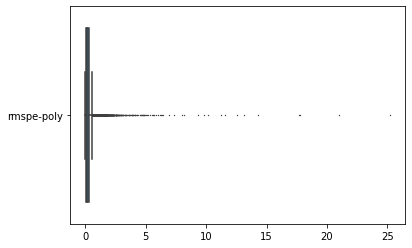

In [197]:
sns.boxplot(data=test[["rmspe-poly"]], orient="h", fliersize=0.5)

<AxesSubplot:>

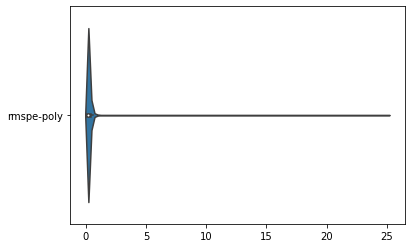

In [198]:
sns.violinplot(data=test[["rmspe-poly"]], orient="h", fliersize=0.5)

<AxesSubplot:>

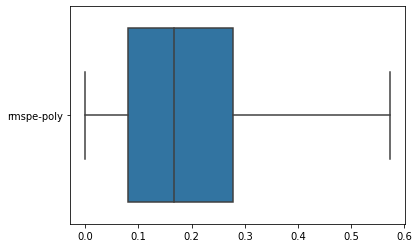

In [199]:
sns.boxplot(data=test[["rmspe-poly"]], orient="h", showfliers=False)

In [200]:
test['rmspe-poly'].describe()

count    428791.000000
mean          0.200436
std           0.194411
min           0.000000
25%           0.080362
50%           0.166522
75%           0.277133
max          25.187903
Name: rmspe-poly, dtype: float64

### Write Predictions to CSV

In [201]:
test = test.astype({'time_id': int, 'stock_id': int})
test

test.to_csv("polyOFIDOM.csv", index=False)

In [202]:
test = pd.read_csv("polyOFIDOM.csv")                          
test                                   

,target_realized_volatility,predicted_volatility,time_id,stock_id,rmspe-poly
0,0.003397,0.003324,103,0,0.021494
1,0.002993,0.004543,146,0,0.517987
2,0.001094,0.001401,250,0,0.280505
3,0.001711,0.001703,297,0,0.004413
4,0.001197,0.003226,319,0,1.694131
...,...,...,...,...,...
428786,0.001746,0.002356,32653,126,0.349894
428787,0.003511,0.003891,32724,126,0.107985
428788,0.010431,0.010095,32746,126,0.032166
428789,0.001827,0.002312,32750,126,0.265366
